### 한줄씩 터미널에 복붙하며 따라해보자(복사는 Ctrl+c, 붙여넣기는 Ctrl+Shift+v)
- git clone https://github.com/withSang/HelloAzureNotebook
    - 이건 이미 돌려봤을 것이다
    - withSang이 만든 HelloAzureNotebook 레포지토리를 자신의 저장소로 복제해온다
    - 새로운 레포지토리를 가져올 때는 항상 이걸로 시작해야 한다
- git config --global user.name "사용자명"
    - git에 사용할 사용자명, 처음 한번만 실행하면 나중에 또 실행할 일은 없다
    - github의 것과 같아도 되고 달라도 된다
- git config --global user.email "이메일"
    - 역시나 github의 것과 달라도 됨, 처음 한번만 실행하면 나중에 또 실행할 일은 없다 
- gif config --global push.default simple
    - 새로운 push 방식을 사용하겠다!, 처음 한번만 실행하면 나중에 또 실행할 일은 없다

- cd HelloAzureNotebook
    - 복제해온 레포지토리 폴더로 이동한다
- git status
    - 상태를 출력해보면 현재 받아온 branch는 master branch임을 알 수 있다

## Azure Notebooks 사용하기
- 의외로 다른게 없다..?
- 아니다. 가상환경에서 돌아가기 때문에 프로그래밍 언어 변경/라이브러리 설치,제거 등이 자유롭다.
- 다만 어디까지나 가상환경 기반이므로 장기간 사용하지 않으면 강제로 커널이 초기화될 수는 있다.

# 예제
- 제임스 마틴 비확산 연구센터(James Martin Center for Nonproliferation Studies)에서 공개한 북한 미사일 발사 실험 일지
    - 위 데이터베이스를 .csv 포맷으로 변환해서 North_Korea_missile_experiments.csv로 저장해 두었다
    - https://www.nti.org/analysis/articles/cns-north-korea-missile-test-database/
- 여기서 **발사에 성공**한 경우만 모은 뒤 지도에 어디서 얼마나 성공했는지를 시각화하려고 한다.

## Basemap 설치하기(Matplotlib 기반 - 지도 시각화를 위해 필요함)

In [1]:
!pip install geos
!pip install https://github.com/matplotlib/basemap/archive/master.zip

     |████████████████████████████████| 368kB 2.6MB/s eta 0:00:01
     |████████████████████████████████| 133.1MB 1.2kB/s eta 0:00:01   |▍                               | 1.4MB 1.0MB/s eta 0:02:08     |██▏                             | 9.1MB 2.9MB/s eta 0:00:43     |███▊                            | 15.5MB 818kB/s eta 0:02:24     |███▉                            | 16.0MB 5.0MB/s eta 0:00:24     |████                            | 16.2MB 5.0MB/s eta 0:00:24     |████                            | 16.6MB 5.0MB/s eta 0:00:24███▌                        | 31.3MB 489kB/s eta 0:03:29.1MB 609kB/s eta 0:02:43.8MB 609kB/s eta 0:02:42��█████▎                      | 38.5MB 177kB/s eta 0:08:53��█████▌                      | 39.6MB 1.5MB/s eta 0:01:02                    | 40.9MB 97kB/s eta 0:15:42                    | 41.7MB 97kB/s eta 0:15:34.1MB 224kB/s eta 0:06:33.0MB 224kB/s eta 0:06:29��█████▎                    | 47.1MB 189kB/s eta 0:07:34��█████▋                    | 48.4MB 189kB/s eta 0:07:27k

Successfully built basemap pyshp


## 본격적으로 코드 짜보기

### 일단 미사일 발사 지점의 위도와 경도가 어떻게 저장되어 있는지 확인한다

In [2]:
with open('North_Korea_missile_experiments.csv', 'r') as csv:
    firstrow = csv.readline().strip().split(',')
    print(firstrow)
    latlon_indexes = [firstrow.index(item) for item in firstrow if item in ['Facility Latitude', 'Facility Longitude']]
    succeed_index = [firstrow.index(item) for item in firstrow if item=='Test Outcome']
    print(latlon_indexes)
    print(succeed_index)

['F1', 'Date', 'Date Entered/Updated', 'Launch Time (UTC)', 'Missile Name', 'Missile Type', 'Launch Agency/Authority', 'Facility Name', 'Facility Location', 'Other Name', 'Facility Latitude', 'Facility Longitude', 'Landing Location', 'Apogee', 'Distance Travelled', 'Confirmation Status', 'Test Outcome']
[10, 11]
[16]


### 이제 numpy를 이용하여 잘 가공한 다음 Basemap으로 시각화한다

In [8]:
?np.genfromtxt

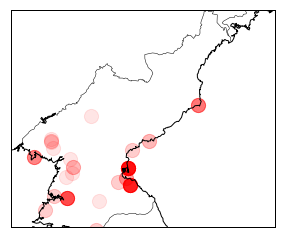

In [17]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

latlon = np.genfromtxt('North_Korea_missile_experiments.csv', delimiter=',', skip_header=1, usecols=[10,11], filling_values=np.nan) #위도, 경도 자료만 빼온다
succeed = np.genfromtxt('North_Korea_missile_experiments.csv', delimiter=',', skip_header=1, usecols=16 , dtype=str)
succeed = np.where(succeed=='Success', 1, 0)
latlon = latlon[succeed==1] #성공한 경우만 남긴다
latlon = latlon[~np.isnan(latlon).any(axis=1)] #np.nan이 1개 이상 든 행들을 제거한다
lat = latlon[:, 0]
lon = latlon[:, 1]

plt.figure()

map = Basemap(projection='merc', lat_0=37.35, lon_0=126.58, resolution = 'i',
    llcrnrlat=38, urcrnrlat=43, llcrnrlon=124, urcrnrlon=132)

x,y = map(lon[:], lat[:])

map.drawcoastlines()
map.drawcountries()
map.drawmapboundary(color='black')
# map.fillcontinents(color='grey')
map.scatter(x, y, alpha=0.1, color='red', s=200)
plt.show()

### Helloworld.ipynb를 완성했다면 아래 내용을 따라해보자
- git add Helloworld.ipynb
    - Helloworld.ipynb 파일을 commit에 넣을 것이라 선언!
    - commit은 수정사항의 단위이다
- git commit -m "Helloworld.ipynb 추가"
    - commit을 추가한다(-m은 커밋에 대한 설명을 넣겠다는 말)
- git push origin master
    - master branch에 자신이 만든 commit을 반영한다
    - 이 때 github 사용자명이랑 비밀번호를 입력해야 한다
    
    
### 기타 - branch 만들고 이동하기, 삭제하기
- git branch <브랜치명>
    - branch를 추가한다
- git checkout <브랜치명>
    - 해당 branch로 이동한다(push하지 않은 것은 모두 날아가니 주의!)
- git branch -d <브랜치명>
    - 해당 branch를 삭제한다
- git merge <브랜치명>
    - 해당 브랜치를 master 브랜치와 병합시킨다